In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
import os
import random
import shutil
import matplotlib.pyplot as plt

# Data Segmentation

In [31]:
# Define the path to your folders
folder_path = './dataset/Datasets'
output_train_path = './dataset/training'
output_val_path = './dataset/validation'

# Define the ratio for splitting data
train_ratio = 0.9  # 90% for training, 10% for validation

# Create directories for training and validation data if they don't exist
os.makedirs(output_train_path, exist_ok=True)
os.makedirs(output_val_path, exist_ok=True)

for folder_name in os.listdir(folder_path):
    folder_path = os.path.join(folder_path, folder_name)

    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        random.shuffle(images)  # Shuffle the images

        # Calculate the split indices based on the ratio
        split_index = int(len(images) * train_ratio)

        # Split the images into training and validation sets
        train_images = images[:split_index]
        val_images = images[split_index:]

        # Create directories for training and validation data for each folder
        train_folder = os.path.join(output_train_path, folder_name)
        val_folder = os.path.join(output_val_path, folder_name)
        os.makedirs(train_folder, exist_ok=True)
        os.makedirs(val_folder, exist_ok=True)

        # Move training images to the training folder with folder structure
        for image in train_images:
            src = os.path.join(folder_path, image)
            dst = os.path.join(train_folder, image)
            shutil.copy(src, dst)

        # Move validation images to the validation folder with folder structure
        for image in val_images:
            src = os.path.join(folder_path, image)
            dst = os.path.join(val_folder, image)
            shutil.copy(src, dst)


In [32]:
train_dir = "./dataset/training/"
valid_dir = "./dataset/validation/"

img_width, img_height = 224, 224  # Default input size for VGG16

In [33]:
# Instantiate convolutional base

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

# Show architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,7))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2407)
validation_features, validation_labels = extract_features(valid_dir, 272)

Found 2407 images belonging to 7 classes.
1/1 [==============================] - 1s 674ms/step
Found 272 images belonging to 7 classes.
1/1 [==============================] - 1s 1s/step


In [37]:
epochs = 150

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 3591 (14.03 KB)
Trainable params: 3591 (14.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
from keras.callbacks import Callback, ModelCheckpoint
# checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

# Compile model
from keras.optimizers import Adam
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
#                     callbacks=[checkpoint],
                    validation_data=(validation_features, validation_labels))

Epoch 1/150
76/76 [==============================] - 1s 4ms/step - loss: 1.8287 - acc: 0.2663 - val_loss: 1.7527 - val_acc: 0.3493
Epoch 2/150
76/76 [==============================] - 0s 2ms/step - loss: 1.7151 - acc: 0.3349 - val_loss: 1.6667 - val_acc: 0.3897
Epoch 3/150
76/76 [==============================] - 0s 2ms/step - loss: 1.6451 - acc: 0.3573 - val_loss: 1.6031 - val_acc: 0.3824
Epoch 4/150
76/76 [==============================] - 0s 2ms/step - loss: 1.5784 - acc: 0.4142 - val_loss: 1.5442 - val_acc: 0.4118
Epoch 5/150
76/76 [==============================] - 0s 2ms/step - loss: 1.5257 - acc: 0.4250 - val_loss: 1.5004 - val_acc: 0.4485
Epoch 6/150
76/76 [==============================] - 0s 2ms/step - loss: 1.4797 - acc: 0.4616 - val_loss: 1.4503 - val_acc: 0.5000
Epoch 7/150
76/76 [==============================] - 0s 2ms/step - loss: 1.4381 - acc: 0.4965 - val_loss: 1.4151 - val_acc: 0.4853
Epoch 8/150
76/76 [==============================] - 0s 2ms/step - loss: 1.4051 - a

Epoch 125/150
76/76 [==============================] - 0s 2ms/step - loss: 0.5916 - acc: 0.8272 - val_loss: 0.7163 - val_acc: 0.7794
Epoch 126/150
76/76 [==============================] - 0s 2ms/step - loss: 0.5906 - acc: 0.8309 - val_loss: 0.7161 - val_acc: 0.7684
Epoch 127/150
76/76 [==============================] - 0s 2ms/step - loss: 0.5882 - acc: 0.8351 - val_loss: 0.7156 - val_acc: 0.7831
Epoch 128/150
76/76 [==============================] - 0s 2ms/step - loss: 0.5857 - acc: 0.8268 - val_loss: 0.7109 - val_acc: 0.7684
Epoch 129/150
76/76 [==============================] - 0s 2ms/step - loss: 0.5857 - acc: 0.8288 - val_loss: 0.7081 - val_acc: 0.7721
Epoch 130/150
76/76 [==============================] - 0s 2ms/step - loss: 0.5811 - acc: 0.8330 - val_loss: 0.7059 - val_acc: 0.7574
Epoch 131/150
76/76 [==============================] - 0s 2ms/step - loss: 0.5781 - acc: 0.8359 - val_loss: 0.7059 - val_acc: 0.7794
Epoch 132/150
76/76 [==============================] - 0s 2ms/step - 

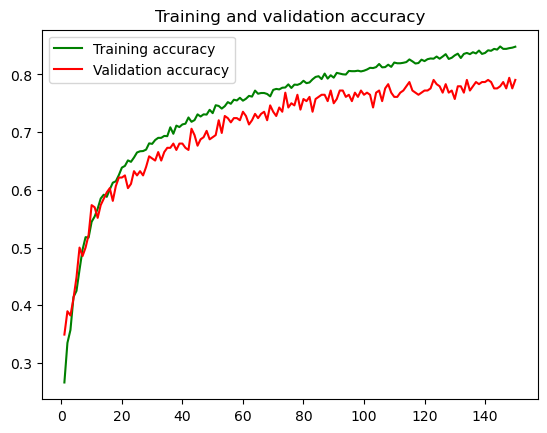

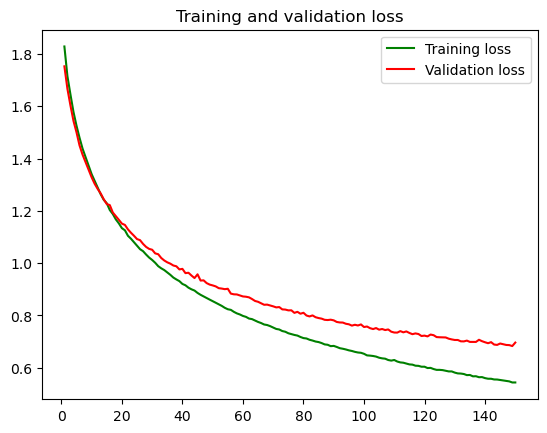

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [52]:
from keras.preprocessing import image
def prediction(img_path):
    org_img = image.load_img(img_path)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

    # Extract features
    features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))
    # Make prediction
    try:
        prediction = model.predict(features)
    except:
        prediction = model.predict(features.reshape(1, 7*7*512))

    classes = ["fifty", "five_hundred", "hundred", "ten", 
               "twenty", "two_hundred", "two_thousand"]
    
    currency = str(classes[np.argmax(np.array(prediction[0]))])
    print(f"Predicted denomiation is {currency}")
    audio(currency)


Testing with random images

In [53]:
pred_dir = "./dataset/validation/twenty/"
import random
pred_files = random.sample(os.listdir(pred_dir),3)
for f in pred_files:
    prediction(pred_dir+f)

1/1 [==============================] - 0s 20ms/step
Predicted denomiation is twenty
1/1 [==============================] - 0s 17ms/step
Predicted denomiation is twenty
1/1 [==============================] - 0s 17ms/step
Predicted denomiation is twenty


# Audio of currency denomination

In [51]:
# Audio Feedback

def audio(currency):
    import pyttsx3

    # Initialize the TTS engine
    engine = pyttsx3.init()

    # Set the speech rate (optional)
    engine.setProperty('rate', 130)  # Adjust the value to control the speech speed

    # Get the recognized denomination
    denomination = currency  # Replace with the recognized denomination from your model

    # Convert the text to speech
    engine.say("The recognized denomination is " + denomination)

    # Play the speech
    engine.runAndWait()


Opens camera and capture the currency image. 

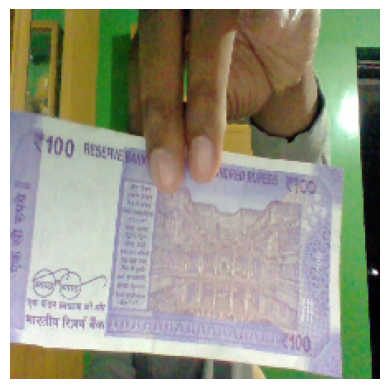

1/1 [==============================] - 0s 16ms/step
Predicted denomiation is hundred


In [56]:
from PIL import Image, ImageOps
import cv2

# Function to capture image from camera
def capture_image():
    camera = cv2.VideoCapture(0)
    while True:
        ret, frame = camera.read()
        cv2.imshow("Capture Image", frame)
        if cv2.waitKey(1) & 0xFF == ord("c"):  # Press 'c' to capture image
            cv2.imwrite("captured_image.jpg", frame)
            break
    camera.release()
    cv2.destroyAllWindows()
    visualize('./captured_image.jpg')

def visualize(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  currency_image = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]

  # Visualizing the captured image
  plt.imshow(currency_image)
  plt.axis('off')
  plt.show()
    
# Capture image
capture_image()
prediction('./captured_image.jpg')